In [13]:
# Install required packages.
!conda install pyg -c pyg
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

Solving environment: ...working... done

# All requested packages already installed.



In [15]:
# import required modules
import pymysql
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# 데이터 불러오기
3점이상 데이터 학습

훈련/검증/테스트 ->80/10/10 비율

In [16]:
#db에서 불렁오기
conn = pymysql.connect(host='mm.noye.work', user='blueturtle', password='flyturtle!', db='booka', charset='utf8mb4')
curs = conn.cursor(pymysql.cursors.DictCursor)
book_path ="Select id,title,author From backend_book"
rating_path="Select score,book_id,user_id From backend_review"
curs.execute(rating_path)
mr=curs.fetchall()
curs.execute(book_path)
mc=curs.fetchall()
df=pd.DataFrame(mr)
df1=pd.DataFrame(mc)


#csv파일 불러오기
#book_path = 'book_info_used.csv'
#rating_path = 'booka_backend_review.csv'

#req_cols = ['user_id', 'book_id', 'score']
#req_cols1 = ['id', 'title', 'author']

#df = pd.read_csv(rating_path,usecols=req_cols, delimiter=',') 
#df1 = pd.read_csv(book_path,usecols=req_cols1,delimiter=',') 


g=df.groupby('score')
g.size()
df

,score,book_id,user_id
0,0,8,35
1,0,76,23
2,0,77,35
3,0,4123,35
4,0,80,35
...,...,...,...
94626,10,112486,14726501
94627,10,453,14726501
94628,10,934,14726501
94629,10,3290,14726501


In [17]:
df.index.unique()

RangeIndex(start=0, stop=94631, step=1)

In [19]:
#유저와 책을 노드로
def load_node_csv(path, index_col):
    
    
    #df = pd.read_csv(path,index_col=index_col,escapechar='\\')
    curs.execute(path)
    mr=curs.fetchall()
    df=pd.DataFrame(mr)
    df=df.set_index(index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping


user_mapping = load_node_csv(rating_path, index_col='user_id')
book_mapping = load_node_csv(book_path, index_col='id')
new_user_mapping={}

len(user_mapping)

10433

In [20]:
# 관계성을 이용해 방금만든 노드로 그래프 만들기
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):

    #df = pd.read_csv(path,escapechar='\\')
    curs.execute(path)
    mr=curs.fetchall()
    df=pd.DataFrame(mr)
    
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold 
    edge_attr2 = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) ==0
    for i in range(edge_attr.shape[0]):
      if(edge_attr[i]==True or edge_attr2[i]==True):
         edge_attr[i]=True
    # True/False 값으로 만들어 임계값이상인 애들만 posedge로 만들자. (1점인 애들을 연결할수는 없으니..)
    print(edge_attr[0])
    
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col='user_id',
    src_mapping=user_mapping,
    dst_index_col='book_id',
    dst_mapping=book_mapping,
    link_index_col='score',
    rating_threshold=7,
)
edge_index
print(len(edge_index[0]))

tensor([True])
78657


In [21]:
#데이터셋 나누기
num_users, num_books = len(user_mapping), len(book_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]
print(len(user_mapping), len(book_mapping))
len(train_edge_index[1])

10433 32544


62925

In [22]:
# 만든 edge를 활용하여 sparse tensor로 만들어줌  https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_books, num_users + num_books))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_books, num_users + num_books))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_books, num_users + num_books))

In [23]:
def sample_mini_batch(batch_size, edge_index):
    
    edges = structured_negative_sampling(edge_index) # i,j,k 형태로 튜플형식으로 반환 
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size) #배치사이즈 개수만큼 랜덤하게 뽑음
    batch = edges[:, indices] #행은 다쓰고 열에서 인덱싱
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [24]:
# lightgcn 모델 정의
class LightGCN(MessagePassing):
    

    def __init__(self, num_users, num_items,device,embedding_dim=64, K=3, add_self_loops=False):
        
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops
        self.lin = torch.nn.Linear(64, 64)
        self.x=torch.tensor([]).to(device)
        self.init_embedding()
        #self.users_emb = nn.Embedding(
            #num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        #self.items_emb = nn.Embedding(
            #num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        #nn.init.normal_(self.users_emb.weight, std=0.1)
        #nn.init.normal_(self.items_emb.weight, std=0.1)

    def init_embedding(self): #유저와 아이템의 수만큼 임베딩을 만들어주고 그 차원은 latent_dim
        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        nn.init.xavier_uniform_(self.users_emb.weight)
        nn.init.xavier_uniform_(self.items_emb.weight)

    def forward(self, edge_index: SparseTensor):

        """
        #norm matrix#
        def gcnnorm(edge_index, edge_weight=None, num_nodes=None, improved=False,
              add_self_loops=True, dtype=None):

          fill_value = 2. if improved else 1.

          if isinstance(edge_index, SparseTensor):
              adj_t = edge_index
              if not adj_t.has_value():
                  adj_t = adj_t.fill_value(1., dtype=dtype)
              if add_self_loops:
                  adj_t = fill_diag(adj_t, fill_value)
              deg = sparsesum(adj_t, dim=1)
              deg_inv_sqrt = deg.pow_(-1)

              deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
              adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
              return adj_t
          """
        
       
        edge_index_norm = gcn_norm(  # diffusion matrix 인듯? symmentrically 정규화 (self-loop 설정가능) 
            edge_index, add_self_loops=self.add_self_loops)
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) 
        embs = [emb_0]
        emb_k = emb_0

        
        emb_k=self.lin(emb_k)
        emb_k=self.lin(emb_k)
        
        
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k) # 내부적으로 message aggregation update를 call 
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        

        #emb_final=(embs[0]+embs[1]*0.4+embs[2]*0.3+embs[3]*0.2)/4
        
        emb_final = torch.mean(embs, dim=1) 
        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) 

        
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def mesage(self, x_j: Tensor,norm) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        
        return matmul(adj_t, x)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")
model = LightGCN(num_users, num_books,device)

Using device cpu.


In [25]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) 

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # positive samples의 스코어 예측
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # negative samples의 스코어 예측

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [26]:
# 각 유저가 본 책의 집합 
def get_user_positive_items(edge_index):
    
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items


In [27]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [28]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [29]:
def get_metrics(model, edge_index, exclude_edge_indices, k):
    
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        
        user_pos_items = get_user_positive_items(exclude_edge_index)
        
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        rating[exclude_users, exclude_items] = -(1 << 10)


    _, top_K_items = torch.topk(rating, k=k)

   
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)


    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [30]:

def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    

    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

In [31]:
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6


In [32]:

model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

In [33]:
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

   
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69313, val_loss: -0.693, val_recall@20: 0.00043, val_precision@20: 0.00013, val_ndcg@20: 0.00022
[Iteration 200/10000] train_loss: -248.05284, val_loss: -18.57111, val_recall@20: 0.08004, val_precision@20: 0.00763, val_ndcg@20: 0.04098
[Iteration 400/10000] train_loss: -5356.44727, val_loss: -410.56363, val_recall@20: 0.0788, val_precision@20: 0.00753, val_ndcg@20: 0.04109
[Iteration 600/10000] train_loss: -29708.0918, val_loss: -2107.20947, val_recall@20: 0.07932, val_precision@20: 0.00745, val_ndcg@20: 0.04114
[Iteration 800/10000] train_loss: -91228.60938, val_loss: -6030.02539, val_recall@20: 0.07792, val_precision@20: 0.00743, val_ndcg@20: 0.0408
[Iteration 1000/10000] train_loss: -207983.76562, val_loss: -13015.92383, val_recall@20: 0.07994, val_precision@20: 0.00756, val_ndcg@20: 0.04126
[Iteration 1200/10000] train_loss: -354962.03125, val_loss: -23554.36523, val_recall@20: 0.07995, val_precision@20: 0.00756, val_ndcg@20: 0.04119
[Iteration 14

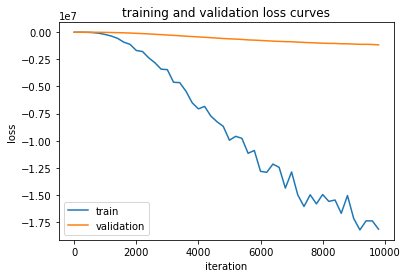

In [34]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [35]:
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}")

[test_loss: -1294334.125, test_recall@20: 0.08076


# 추천

In [36]:
model.eval()
#df = pd.read_csv(book_path,escapechar='\\')
curs.execute(book_path)
mr=curs.fetchall()
df=pd.DataFrame(mr)
bookid_title = pd.Series(df.title.values,index=df.id).to_dict()
bookid_authors = pd.Series(df.author.values,index=df.id).to_dict()

user_pos_items = get_user_positive_items(edge_index)

OperationalError: (2006, "MySQL server has gone away (ConnectionResetError(10054, '현재 연결은 원격 호스트에 의해 강제로 끊겼습니다', None, 10054, None))")

In [ ]:
def make_predictions(user_id, num_recs):
    user=user_id
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    new_user_mapping={}
    for k,v in user_mapping.items():
      new_user_mapping[v]=k 

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs) 

    print(len(user_pos_items[user]) + num_recs)
    

    books = [index for index in user_pos_items[user]] #해당 유저가 3점이상으로 매기 아이템 다가져옴
    book_ids = [list(book_mapping.keys())[list(book_mapping.values()).index(book)] for book in books]
    print(book_ids)
    titles = [bookid_title[id] for id in book_ids]
    authors = [bookid_authors[id] for id in book_ids]

    print(f"Here are some books read by {new_user_mapping[user]}  user")
    for i in range(len(books)):
        print(f"title: {titles[i]}, author: {authors[i]} ")

    print()

    books = [index.cpu().item() for index in indices if index not in user_pos_items[user]]
    book_ids = [list(book_mapping.keys())[list(book_mapping.values()).index(book)] for book in books]
    titles = [bookid_title[id] for id in book_ids]
    authors = [bookid_authors[id] for id in book_ids]

    print(f"Here are some suggested book for user {new_user_mapping[user]}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, author: {authors[i]} ")

In [ ]:
user=edge_index[0].tolist()
user=set(user)
user=list(user)
print(len(user))
count=0

for i in user:
  USER_ID = i
  NUM_RECS = 15
  make_predictions(USER_ID, NUM_RECS)
  print("\n")
  count+=1
  if(count==50): break

In [ ]:
item_e=model.items_emb.weight
item_e=item_e.detach().numpy()
df_item=pd.DataFrame(item_e)
df_item

user_e=model.users_emb.weight
user_e=user_e.detach().numpy()
df_user=pd.DataFrame(user_e)
df_user

df_item.index

In [ ]:
new_user_mapping={}
for k,v in user_mapping.items():
    new_user_mapping[v]=k 
list_index=[]

for index in df_user.index:
    list_index.append(new_user_mapping[index])
list_index
df_user.index=list_index
df_user

In [ ]:
new_book_mapping={}
for k,v in book_mapping.items():
    new_book_mapping[v]=k 
list_index=[]

for index in df_item.index:
    list_index.append(new_book_mapping[index])
df_item.index=list_index
df_item

In [ ]:
d_item=dict()
count=0
for i in df_item.index:
    d_item[i]=df_item.iloc[count].values.tolist()
    count+=1
d_item  

In [ ]:
d_user=dict()
count=0
for i in df_user.index:
    d_user[i]=df_user.iloc[count].values.tolist()
    count+=1
d_user  

In [ ]:
import pickle
 
## Save pickle
with open("data.pickleu","wb") as fw:
    pickle.dump(d_user, fw)
 
## Load pickle
with open("data.pickleu","rb") as fr:
    data = pickle.load(fr)



    
    
    
with open("data.picklee","wb") as fw:
    pickle.dump(d_item, fw)
 
## Load pickle
with open("data.picklee","rb") as fr:
    data = pickle.load(fr)